In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
cd drive/My Drive/icaria_pre_task/mfeat

/content/drive/My Drive/icaria_pre_task/mfeat


In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

##fou 76個のフーリエ変換

In [18]:
# csv fileのデータを整形する(各係数とtarget)
fou_df = pd.read_csv("mfeat-fou.csv",header=None)
fou_df.head() #一つのcolumnに全ての係数が入っている

,0
0,0.06588172 0.19731169 0.10382563 0.270361...
1,0.04914215 0.17597068 0.10551464 0.227094...
2,0.03417192 0.22764888 0.10876636 0.127696...
3,0.06233634 0.21797938 0.08024345 0.289591...
4,0.06196956 0.19835840 0.11123936 0.253460...


In [0]:
# 各係数をcolumnにする関数を作成
def create_new_df(df):
  df_array =np.array(df)
  new_list = []
  for i in range(len(df_array)):
    cofficients = df_array[i][0].rstrip().split(' ')
    coefficient_list = []
    for j in cofficients:
      if j:
        coefficient_list.append(float(j))
    new_list += [coefficient_list]
  new_array = np.array(new_list)
  new_df = pd.DataFrame(new_array)
  return new_df

In [0]:
new_fou_df = create_new_df(fou_df)

In [0]:
new_fou_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75
0,0.065882,0.197312,0.103826,0.270362,0.616078,0.035856,0.424572,0.089701,0.367773,0.037065,0.075942,0.263906,0.077903,0.372009,0.219485,0.055327,0.108906,0.127752,0.114051,0.018581,0.102627,0.172682,0.073033,0.140344,0.132199,0.076015,0.032517,0.128840,0.120526,0.016615,0.102583,0.101625,0.065730,0.035213,0.079009,0.083773,0.021491,0.121625,0.067512,0.033777,0.099013,0.059408,0.081286,0.052345,0.090500,0.063582,0.081104,0.059101,0.097236,0.041576,0.083515,0.042379,0.082965,0.077170,0.116732,0.034761,0.109485,0.016423,0.099352,0.113763,0.086372,0.167654,0.106281,0.125783,0.090675,0.081256,0.123448,0.113374,0.074343,0.281666,0.067795,0.344182,0.038963,0.394366,0.049971,0.344871
1,0.049142,0.175971,0.105515,0.227095,0.599280,0.041217,0.431078,0.096801,0.326739,0.059661,0.017184,0.314690,0.012904,0.453107,0.209364,0.053331,0.081334,0.007550,0.234876,0.043490,0.019631,0.161129,0.044329,0.132679,0.130415,0.073866,0.051192,0.030221,0.144867,0.023895,0.016790,0.121181,0.076889,0.054896,0.088678,0.097209,0.019548,0.026906,0.113283,0.020423,0.024929,0.085364,0.090844,0.011986,0.092177,0.072633,0.006894,0.040413,0.007373,0.030241,0.088277,0.101808,0.082933,0.117419,0.030040,0.122958,0.015721,0.081246,0.054884,0.087803,0.069228,0.145889,0.019964,0.193200,0.014135,0.131552,0.045310,0.069337,0.045386,0.254264,0.045447,0.335659,0.021719,0.445277,0.083978,0.354092
2,0.034172,0.227649,0.108766,0.127697,0.612494,0.056554,0.470639,0.041903,0.324267,0.044569,0.017012,0.283372,0.060468,0.364420,0.218012,0.065799,0.100798,0.041148,0.103112,0.029623,0.016676,0.126331,0.073546,0.160574,0.127323,0.076715,0.058565,0.007764,0.074607,0.021533,0.016114,0.090223,0.077979,0.090263,0.072140,0.091450,0.035295,0.020528,0.063147,0.022222,0.038475,0.054014,0.094508,0.039474,0.086138,0.071334,0.014315,0.059481,0.019133,0.046476,0.054556,0.101624,0.073648,0.117885,0.032529,0.057997,0.029461,0.040950,0.033732,0.218233,0.051349,0.190854,0.045106,0.180896,0.036688,0.082467,0.019858,0.218842,0.041087,0.360464,0.047154,0.377408,0.052099,0.445029,0.071234,0.261465
3,0.062336,0.217979,0.080243,0.289592,0.546316,0.045779,0.425545,0.022841,0.331454,0.119052,0.036931,0.224981,0.051425,0.337966,0.152098,0.072680,0.162303,0.037585,0.056670,0.106918,0.017703,0.109614,0.076275,0.187445,0.059987,0.087590,0.113050,0.038817,0.034270,0.088544,0.018063,0.043295,0.089820,0.156005,0.018523,0.088568,0.092721,0.036220,0.045108,0.066557,0.035874,0.013387,0.087210,0.087777,0.076711,0.019268,0.079736,0.044408,0.043399,0.069940,0.067212,0.010513,0.085155,0.017055,0.073653,0.083279,0.020877,0.105687,0.081941,0.023220,0.089021,0.062116,0.069341,0.158564,0.011687,0.165806,0.083995,0.085479,0.087658,0.151880,0.075950,0.293462,0.022675,0.408291,0.063010,0.401376
4,0.061970,0.198358,0.111239,0.253460,0.608455,0.023631,0.415246,0.091866,0.309310,0.049142,0.093298,0.315552,0.051809,0.388674,0.216835,0.049581,0.049233,0.156873,0.206554,0.042255,0.102949,0.155439,0.059885,0.058975,0.125538,0.058147,0.067630,0.148337,0.117097,0.050259,0.078909,0.085289,0.082221,0.080176,0.076863,0.058436,0.062460,0.082330,0.045987,0.043482,0.067768,0.060132,0.063493,0.070777,0.047835,0.072733,0.076327,0.056720,0.066385,0.052332,0.049535,0.084414,0.048125,0.107442,0.057394,0.108580,0.072844,0.071208,0.052613,0.102777,0.026283,0.162884,0.063546,0.185552,0.050646,0.130661,0.021004,0.106960,0.032283,0.248565,0.015674,0.386276,0.039481,0.434701,0.069218,0.405403


In [0]:
# targetの追加
def add_target(df):
  df['target'] = 0
  df['target'][200:400] = 1
  df['target'][400:600] = 2
  df['target'][600:800] = 3
  df['target'][800:1000] = 4
  df['target'][1000:1200] = 5
  df['target'][1200:1400] = 6
  df['target'][1400:1600] = 7
  df['target'][1600:1800] = 8
  df['target'][1800:2000] = 9
  return df

In [20]:
new_fou_df = add_target(new_fou_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages

## 各特徴量のクラスごとの平均値をプロットする

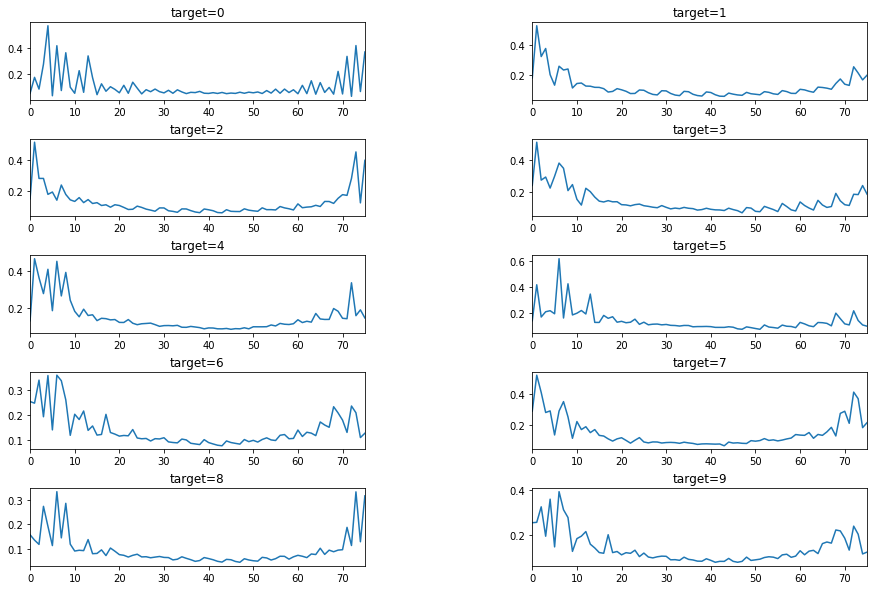

In [0]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(wspace=0.5,hspace=0.5)

for i in range(10):
  plt.subplot(5,2,i+1)
  mean_df = new_fou_df[new_fou_df['target']==i].drop('target',axis=1).mean(axis=0)
  mean_df.plot()
  plt.title('target={}'.format(i))
  #plt.show()
plt.show()

### グラフの前半部分と後半部分に特徴が見られる。6と9,1と7の前半部分の形状が似ている。

Text(0.5, 1.0, 'target=1')

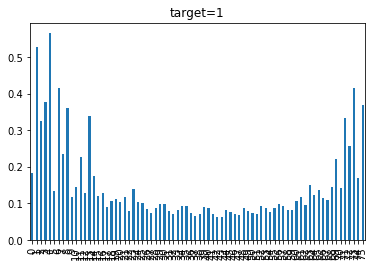

In [0]:
plt.figure()
mean_df = new_fou_df[new_fou_df['target']==0].drop('target',axis=1).mean(axis=0)
mean_df.plot.bar()
plt.title('target={}'.format(0))
mean_df2 = new_fou_df[new_fou_df['target']==1].drop('target',axis=1).mean(axis=0)
mean_df2.plot.bar()
plt.title('target={}'.format(1))

In [0]:
target = new_fou_df['target']
del new_fou_df['target']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(new_fou_df, target, test_size=0.2)

In [0]:
# svcのgrid_search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],  'gamma' : [0.001, 0.01, 0.1, 1, 10, 100], 'kernel' : ['rbf', 'linear', 'poly']}
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train.values, y_train.values)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                         'kernel': ['rbf', 'linear', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
print('Test set score: {}'.format(grid_search.score(X_test.values, y_test.values)))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation: {}'.format(grid_search.best_score_))

Test set score: 0.8225
Best parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Best cross-validation: 0.873125


In [0]:
# logistic_regression 
folds = KFold(n_splits=5, shuffle=True, random_state=123)
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])
features = [f_ for f_ in X_train.columns if f_ not in ["target"]]
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_train)):
    trn_x, trn_y = X_train[features].iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = X_train[features].iloc[val_idx], y_train.iloc[val_idx]
    clf = LogisticRegression(solver='lbfgs',multi_class='multinomial')
    clf.fit(trn_x, trn_y)
    print(clf.score(val_x, val_y))

print("testACC{}".format(clf.score(X_test.values, y_test.values)))

0.84375
0.81875
0.7875
0.7875
0.7875
testACC0.78


###76のフーリエ変換の係数を特徴量とした場合にSVMで85%ロジスティック回帰で80%のaccuracyが得られることがわかる。


## fac:216個のプロファイル相関

In [21]:
fac_df = pd.read_csv("mfeat-fac.csv",header=None)
fac_df.head() #一つのcolumnに全ての係数が入っている

,0
0,98 236 531 673 607 647 2 9 3 ...
1,121 193 607 611 585 665 7 9 2 ...
2,115 141 590 605 557 627 12 6 3 ...
3,90 122 627 692 607 642 0 6 4 ...
4,157 167 681 666 587 666 8 6 1 ...


In [22]:
new_fac_df = create_new_df(fac_df)
new_fac_df = add_target(new_fac_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages

In [0]:
new_fac_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,target
0,98.0,236.0,531.0,673.0,607.0,647.0,2.0,9.0,3.0,6.0,8.0,5.0,225.0,517.0,652.0,624.0,628.0,994.0,7.0,22.0,28.0,13.0,10.0,19.0,305.0,481.0,667.0,663.0,1009.0,727.0,38.0,28.0,18.0,11.0,20.0,10.0,287.0,567.0,651.0,742.0,...,12.0,19.0,10.0,360.0,328.0,607.0,984.0,1186.0,599.0,29.0,7.0,14.0,6.0,9.0,9.0,362.0,314.0,924.0,733.0,601.0,1216.0,4.0,8.0,20.0,10.0,9.0,5.0,251.0,421.0,474.0,536.0,628.0,632.0,18.0,36.0,8.0,15.0,12.0,13.0,0
1,121.0,193.0,607.0,611.0,585.0,665.0,7.0,9.0,2.0,4.0,3.0,7.0,214.0,514.0,690.0,548.0,630.0,1006.0,2.0,18.0,31.0,15.0,5.0,15.0,260.0,344.0,655.0,605.0,993.0,743.0,29.0,32.0,25.0,11.0,17.0,6.0,308.0,412.0,719.0,700.0,...,8.0,18.0,8.0,351.0,249.0,687.0,922.0,1194.0,617.0,26.0,11.0,11.0,4.0,10.0,7.0,347.0,439.0,950.0,675.0,577.0,1222.0,13.0,6.0,27.0,10.0,10.0,3.0,224.0,354.0,520.0,458.0,570.0,634.0,15.0,32.0,11.0,13.0,15.0,11.0,0
2,115.0,141.0,590.0,605.0,557.0,627.0,12.0,6.0,3.0,3.0,5.0,4.0,196.0,404.0,611.0,560.0,594.0,986.0,7.0,21.0,28.0,14.0,7.0,12.0,278.0,406.0,670.0,579.0,991.0,703.0,24.0,29.0,18.0,12.0,19.0,9.0,378.0,468.0,668.0,654.0,...,9.0,20.0,13.0,415.0,323.0,672.0,896.0,1168.0,595.0,21.0,8.0,14.0,3.0,10.0,12.0,343.0,365.0,877.0,663.0,547.0,1192.0,18.0,7.0,20.0,13.0,10.0,2.0,196.0,348.0,535.0,498.0,572.0,656.0,20.0,35.0,16.0,14.0,13.0,6.0,0
3,90.0,122.0,627.0,692.0,607.0,642.0,0.0,6.0,4.0,5.0,3.0,5.0,201.0,445.0,664.0,629.0,626.0,945.0,5.0,21.0,27.0,16.0,7.0,9.0,273.0,397.0,703.0,662.0,987.0,710.0,36.0,29.0,21.0,8.0,15.0,10.0,331.0,459.0,731.0,765.0,...,7.0,16.0,10.0,380.0,354.0,711.0,987.0,1180.0,606.0,27.0,8.0,15.0,5.0,12.0,9.0,400.0,358.0,918.0,756.0,603.0,1171.0,6.0,7.0,23.0,11.0,12.0,5.0,263.0,419.0,576.0,549.0,628.0,621.0,16.0,35.0,7.0,12.0,15.0,9.0,0
4,157.0,167.0,681.0,666.0,587.0,666.0,8.0,6.0,1.0,4.0,5.0,5.0,212.0,386.0,740.0,613.0,614.0,997.0,5.0,21.0,30.0,11.0,7.0,17.0,248.0,390.0,703.0,662.0,949.0,744.0,28.0,29.0,20.0,13.0,19.0,10.0,244.0,468.0,797.0,743.0,...,8.0,20.0,6.0,337.0,303.0,763.0,989.0,1156.0,628.0,29.0,8.0,12.0,2.0,10.0,7.0,321.0,337.0,988.0,726.0,577.0,1225.0,14.0,7.0,22.0,8.0,10.0,5.0,276.0,342.0,594.0,525.0,568.0,653.0,16.0,35.0,10.0,15.0,13.0,13.0,0


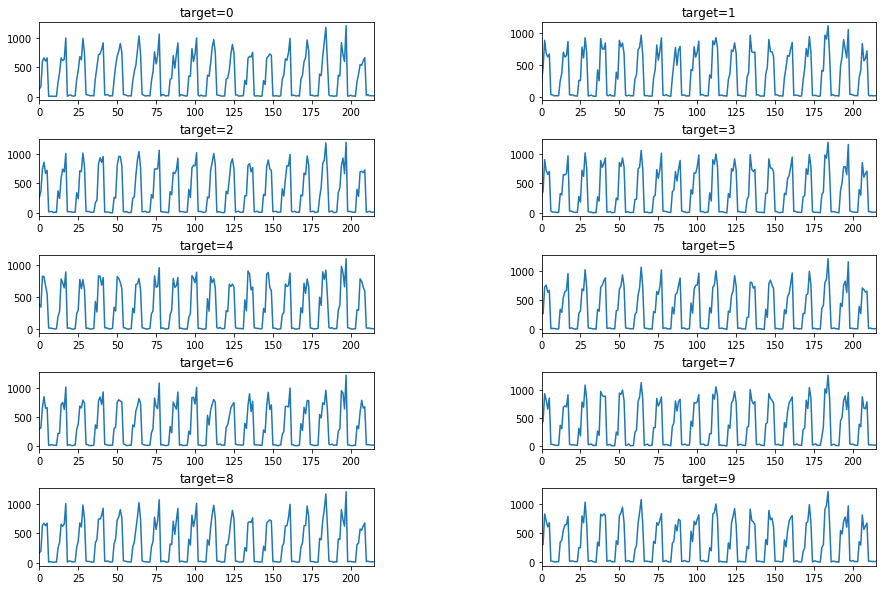

In [0]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(wspace=0.5,hspace=0.5)

for i in range(10):
  plt.subplot(5,2,i+1)
  mean_df = new_fac_df[new_fac_df['target']==i].drop('target',axis=1).mean(axis=0)
  mean_df.plot()
  plt.title('target={}'.format(i))
  #plt.show()
plt.show()

In [0]:
target = new_fac_df['target']
del new_fac_df['target']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(new_fac_df, target, test_size=0.2)

In [0]:
# svcのgrid_search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],  'gamma' : [0.001, 0.01, 0.1, 1, 10, 100], 'kernel' : ['rbf', 'linear', 'poly']}
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train.values, y_train.values)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'gamma': [0.001, 0.01, 0.1, 1, 10, 100],
                         'kernel': ['rbf', 'linear', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [0]:
print('Test set score: {}'.format(grid_search.score(X_test.values, y_test.values)))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation: {}'.format(grid_search.best_score_))

Test set score: 0.975
Best parameters: {'C': 0.001, 'gamma': 0.001, 'kernel': 'poly'}
Best cross-validation: 0.968125


In [0]:
# logistic_regression 
folds = KFold(n_splits=5, shuffle=True, random_state=123)
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])
features = [f_ for f_ in X_train.columns if f_ not in ["target"]]
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_train)):
    trn_x, trn_y = X_train[features].iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = X_train[features].iloc[val_idx], y_train.iloc[val_idx]
    clf = LogisticRegression(solver='lbfgs',multi_class='multinomial')
    clf.fit(trn_x, trn_y)
    print(clf.score(val_x, val_y))

print("testACC{}".format(clf.score(X_test, y_test)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.95625


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.975


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.946875


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.953125
0.953125
testACC0.945


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


###216個のプロファイル相関を特徴量とした時SVM、ロジスティック回帰いずれも97%以上の精度である。すなわちtargetに対して重要な特徴量と言える。

## 64個のKL変換

In [25]:
kar_df = pd.read_csv("mfeat-kar.csv",header=None) #一つのcolumnに全ての係数が入っている
new_kar_df = create_new_df(kar_df)
new_kar_df = add_target(new_kar_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages

In [0]:
new_kar_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,target
0,-10.297008,-11.666789,11.560669,-2.081316,4.044656,4.086815,-2.558072,-8.476935,2.138135,3.503082,-0.064074,0.983302,2.001344,1.478683,-0.402921,1.609768,-2.627923,2.741715,-2.283389,1.239708,-1.827247,-1.581615,2.027865,-0.394052,-1.446159,-0.603834,2.475224,-1.096591,1.311422,-0.346206,-0.822164,-1.012095,1.620569,0.262893,0.457352,1.365226,-1.121445,-0.071175,-0.914878,-1.440099,-2.192526,0.830108,0.452905,1.085592,1.960389,-0.877156,0.377651,-0.307988,-0.017944,0.442649,0.620422,-1.135986,0.088799,0.186969,1.078083,0.921927,0.496387,-0.643667,0.284104,0.286555,0.348625,1.814691,-1.351353,-0.473910,0
1,-5.036009,-12.885333,0.161155,0.592460,3.123534,4.220469,-6.411771,-6.335328,-0.244622,1.346073,-1.888005,-1.425509,3.546106,-2.728002,0.145671,0.144373,1.070799,1.676834,3.458105,2.141824,-0.008930,-1.899805,-0.201592,0.386368,0.325236,-0.857551,2.599812,0.646875,-0.884929,-0.789922,-1.011073,1.085249,-1.010811,-0.528006,-0.950611,0.866379,-1.174443,-0.125630,0.683759,-0.280212,-0.658064,-0.099992,3.127316,0.214157,-0.783071,-0.427827,-2.560559,-1.627720,-1.475449,0.087514,-0.669465,-1.378673,-1.568273,-1.133077,0.942353,2.938791,1.429883,-2.336344,1.281628,-0.098321,0.582357,0.485792,0.642451,0.613107,0
2,-9.639157,-6.655898,0.388687,-1.717650,0.300346,3.400769,-7.240785,-1.659405,-0.874005,4.153403,-4.732827,2.371873,-0.791784,2.609470,-2.203911,-4.435813,-0.762313,-0.394081,1.133503,2.644041,-3.876470,3.067372,-0.150997,-0.814162,1.290007,-0.885316,2.597499,-3.268025,-1.777111,-0.259310,-2.887960,0.803436,0.885987,1.164181,-2.672265,0.213014,2.502617,0.011691,-0.241381,-0.503143,-2.017740,0.623053,0.297995,0.453539,-0.523467,1.172609,-1.034330,-1.045539,-1.519977,1.578619,0.772292,-1.644673,0.555195,0.372116,-0.413174,-0.023028,-0.025265,1.259838,-0.441360,-0.960094,1.995843,1.097748,0.827182,-1.767840,0
3,-6.650375,-7.043851,4.104350,-2.342780,3.494658,3.924822,-9.874812,-6.556576,-1.364269,1.153308,-0.525791,1.306552,3.489466,3.987592,-1.356328,-0.857526,1.180557,-4.406371,-1.761988,2.742064,-1.601306,0.721423,2.888973,-0.984098,-0.900931,0.280389,0.000239,-2.231012,-1.077999,-1.499626,-2.011180,0.741876,-0.303120,0.149713,0.072599,-2.515244,0.593984,-1.342731,0.454232,-0.989877,0.388920,-0.539341,0.833950,-0.292633,0.001021,0.540339,0.858158,-0.727200,1.441517,-0.133205,-1.072086,-1.575707,0.276112,-0.553317,-0.961236,-1.043815,-0.204508,-1.981150,0.982438,-0.144233,-1.449328,-0.913552,-0.771735,0.304992,0
4,-10.664524,-10.974133,0.194391,0.453885,2.193088,-3.304663,-8.376592,-4.241146,2.964818,-0.949622,-1.493196,-1.325390,1.729491,-0.638025,-1.785161,1.266107,0.683632,3.106049,0.812620,1.709782,1.845162,-2.602056,-0.005624,-0.149866,0.549093,-1.272378,1.982501,1.106768,0.183949,0.061280,0.402014,0.814850,-3.796409,-1.317945,-1.210731,-1.223604,-1.281105,0.352830,0.264770,-1.295441,-1.482741,-0.568190,0.887338,2.180462,2.439588,1.228399,-2.084001,0.315359,-0.877886,0.848514,-0.654705,-0.406145,-0.335391,-0.722847,0.152957,1.448160,-1.254907,-3.481295,-0.563889,1.529335,0.510399,0.298318,-0.943213,1.149847,0


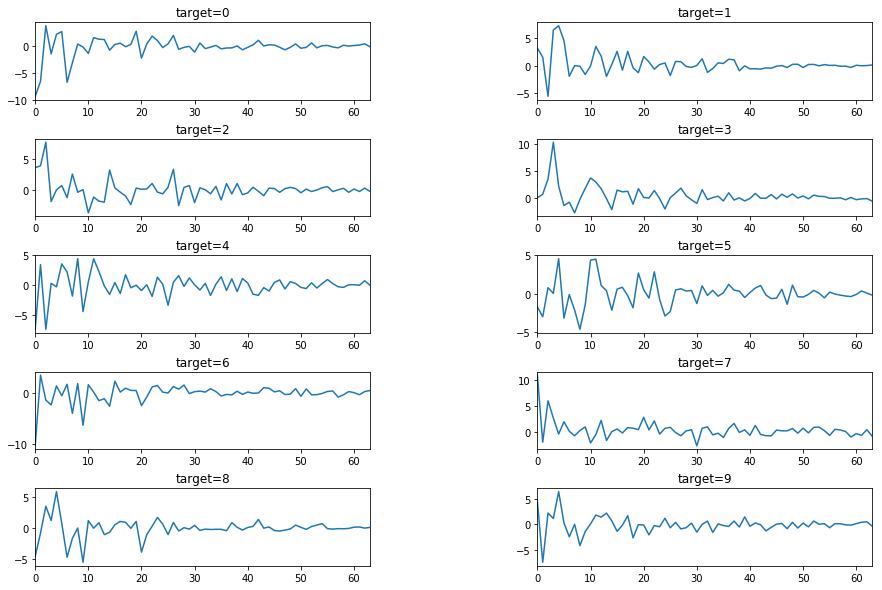

In [0]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(wspace=0.5,hspace=0.5)

for i in range(10):
  plt.subplot(5,2,i+1)
  mean_df = new_kar_df[new_kar_df['target']==i].drop('target',axis=1).mean(axis=0)
  mean_df.plot()
  plt.title('target={}'.format(i))
  #plt.show()
plt.show()

In [0]:
target = new_kar_df['target']
del new_kar_df['target']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(new_kar_df, target, test_size=0.2)

In [0]:
# svcのgrid_search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],  'gamma' : [0.001, 0.01, 0.1, 1, 10, 100], 'kernel' : ['rbf', 'linear', 'poly']}
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train.values, y_train.values)

In [0]:
print('Test set score: {}'.format(grid_search.score(X_test.values, y_test.values)))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation: {}'.format(grid_search.best_score_))

In [0]:
# logistic_regression 
folds = KFold(n_splits=5, shuffle=True, random_state=123)
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])
features = [f_ for f_ in X_train.columns if f_ not in ["target"]]
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_train)):
    trn_x, trn_y = X_train[features].iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = X_train[features].iloc[val_idx], y_train.iloc[val_idx]
    clf = LogisticRegression(solver='lbfgs',multi_class='multinomial')
    clf.fit(trn_x, trn_y)
    print(clf.score(val_x, val_y))

print("testACC{}".format(clf.score(X_test, y_test)))

In [27]:
## mfeat-pix 240pixelの平均値 2*3window
pix_df = pd.read_csv("mfeat-pix.csv",header=None) #一つのcolumnに全ての係数が入っている
new_pix_df = create_new_df(pix_df)
new_pix_df = add_target(new_pix_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages

In [0]:
new_pix_df.head()

In [0]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(wspace=0.5,hspace=0.5)

for i in range(10):
  plt.subplot(5,2,i+1)
  mean_df = new_pix_df[new_pix_df['target']==i].drop('target',axis=1).mean(axis=0)
  mean_df.plot()
  plt.title('target={}'.format(i))
  #plt.show()
plt.show()

In [0]:
target = new_pix_df['target']
del new_pix_df['target']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(new_kar_df, target, test_size=0.2)

In [0]:
# svcのgrid_search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],  'gamma' : [0.001, 0.01, 0.1, 1, 10, 100], 'kernel' : ['rbf', 'linear', 'poly']}
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train.values, y_train.values)

In [0]:
print('Test set score: {}'.format(grid_search.score(X_test.values, y_test.values)))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation: {}'.format(grid_search.best_score_))

In [0]:
# logistic_regression 
folds = KFold(n_splits=5, shuffle=True, random_state=123)
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])
features = [f_ for f_ in X_train.columns if f_ not in ["target"]]
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_train)):
    trn_x, trn_y = X_train[features].iloc[trn_idx], y_train.iloc[trn_idx
    val_x, val_y = X_train[features].iloc[val_idx], y_train.iloc[val_idx]
    clf = LogisticRegression(solver='lbfgs',multi_class='multinomial')
    clf.fit(trn_x, trn_y)
    print(clf.score(val_x, val_y))

print("testACC{}".format(clf.score(X_test, y_test)))

## 47のゼルニケ多項式

In [29]:
## mfeat-zer 47のゼルニケ多項式
zer_df = pd.read_csv("mfeat-zer.csv",header=None) #一つのcolumnに全ての係数が入っている
new_zer_df = create_new_df(zer_df)
new_zer_df = add_target(new_zer_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages

In [0]:
new_zer_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,target
0,0.011033,0.831466,15.351804,75.806559,171.554214,490.156556,206.416027,0.122135,2.601646,11.472709,20.043415,110.868301,99.025277,0.100592,4.465825,37.203673,71.682698,303.833008,444.818734,0.324292,2.808212,7.505539,14.199325,109.820532,0.623083,11.902597,13.992883,6.972559,484.784871,0.344745,6.836616,41.172862,67.583218,1.875599,2.280403,170.265764,158.818410,1.713529,33.810340,9.858915,1.399891,148.138058,326.239452,9.711070,20.007248,47.032578,539.208457,0
1,0.038271,1.166746,10.526913,42.369276,85.187116,420.360566,253.569574,0.033657,0.390566,11.700830,65.596013,97.691050,87.946417,0.136957,3.005241,22.837229,40.656873,186.411684,419.543064,0.054929,3.576323,38.546889,100.034785,85.145611,0.414205,8.006745,53.191399,91.367313,371.994407,0.531269,14.376516,74.169044,82.063449,1.348741,29.158736,211.200298,34.597257,2.590208,35.400531,70.681899,6.674412,155.135985,377.832675,8.140633,44.536711,46.338954,518.496567,0
2,0.042698,1.225007,8.273804,31.744786,54.448177,404.103204,389.980746,0.041733,0.937399,11.629045,33.481501,51.705886,17.760377,0.138112,2.376392,20.892105,68.666675,168.420731,518.229961,0.113119,3.380604,21.119272,52.675563,11.774172,0.328196,7.781216,71.369955,94.039942,402.482819,0.482565,8.101806,40.012973,14.869455,1.336517,35.772897,207.147093,10.924662,1.476285,19.477230,30.093590,7.858211,150.126419,419.565747,4.530921,26.292170,44.574822,549.912691,0
3,0.032418,1.638247,19.205283,51.196682,57.181760,429.052011,256.174645,0.073624,1.973268,13.057108,36.079443,49.978731,55.037174,0.190329,5.212415,25.128272,51.937089,178.923865,386.324218,0.245137,3.963072,20.036877,27.570634,80.054547,0.692839,8.226120,61.257439,112.688600,324.849754,0.583625,7.453045,23.667204,65.148691,1.326251,31.813000,239.672998,21.054749,1.349613,14.179518,30.564085,7.097728,173.840759,441.350376,3.706023,13.432311,51.739930,574.887814,0
4,0.015866,0.611561,8.627839,37.325052,48.509025,459.909634,238.572767,0.046477,1.117292,10.012169,27.169266,67.849862,71.512437,0.076843,2.660718,24.901428,61.750370,216.615177,417.658858,0.144952,3.055750,12.775389,47.312230,66.377015,0.384703,9.695486,75.963320,86.050213,399.975218,0.452419,4.055963,23.946695,50.192029,1.721486,40.003794,222.227638,83.421886,0.667971,8.705403,30.242473,9.015714,167.021185,332.479997,1.806273,23.689300,50.407770,492.227513,0


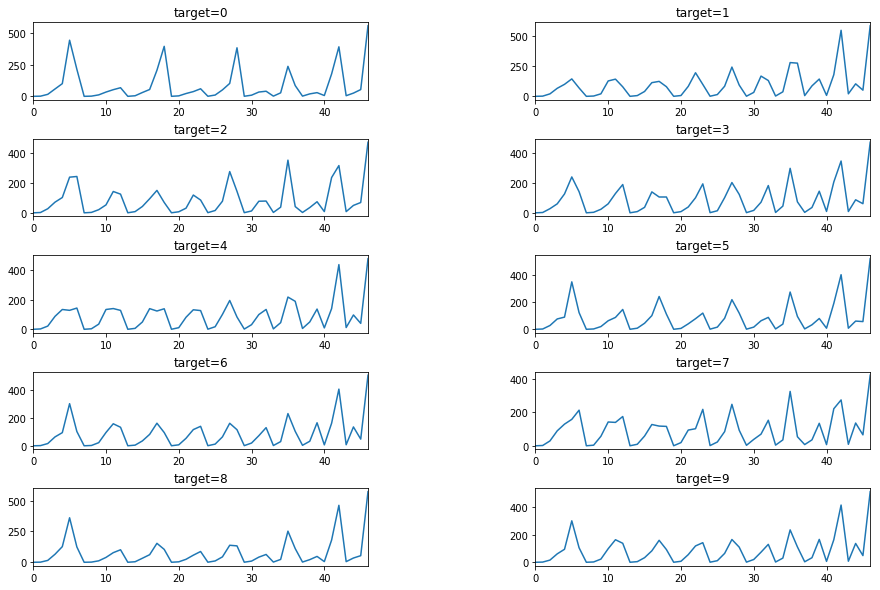

In [0]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(wspace=0.5,hspace=0.5)

for i in range(10):
  plt.subplot(5,2,i+1)
  mean_df = new_zer_df[new_zer_df['target']==i].drop('target',axis=1).mean(axis=0)
  mean_df.plot()
  plt.title('target={}'.format(i))
  #plt.show()
plt.show()

In [0]:
target = new_zer_df['target']
del new_zer_df['target']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(new_kar_df, target, test_size=0.2)

In [0]:
# svcのgrid_search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],  'gamma' : [0.001, 0.01, 0.1, 1, 10, 100], 'kernel' : ['rbf', 'linear', 'poly']}
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train.values, y_train.values)

In [0]:
print('Test set score: {}'.format(grid_search.score(X_test.values, y_test.values)))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation: {}'.format(grid_search.best_score_))

In [0]:
# logistic_regression 
folds = KFold(n_splits=5, shuffle=True, random_state=123)
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])
features = [f_ for f_ in X_train.columns if f_ not in ["target"]]
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_train)):
    trn_x, trn_y = X_train[features].iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = X_train[features].iloc[val_idx], y_train.iloc[val_idx]
    clf = LogisticRegression(solver='lbfgs',multi_class='multinomial')
    clf.fit(trn_x, trn_y)
    print(clf.score(val_x, val_y))

print("testACC{}".format(clf.score(X_test, y_test)))

###6つの形態学的特徴

In [6]:
mor_df = pd.read_csv("mfeat-mor.csv",header=None) #一つのcolumnに全ての係数が入っている
new_mor_df = create_new_df(mor_df)
new_mor_df = add_target(new_mor_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages

In [7]:
new_mor_df.head()

,0,1,2,3,4,5,target
0,1.0,0.0,0.0,133.150861,1.311693,1620.221779,0
1,1.0,0.0,0.0,126.724861,1.302745,1609.334822,0
2,1.0,0.0,0.0,131.173861,1.319031,1568.978435,0
3,1.0,0.0,0.0,129.478861,1.270878,1695.055281,0
4,1.0,0.0,0.0,127.262861,1.329637,1647.720235,0


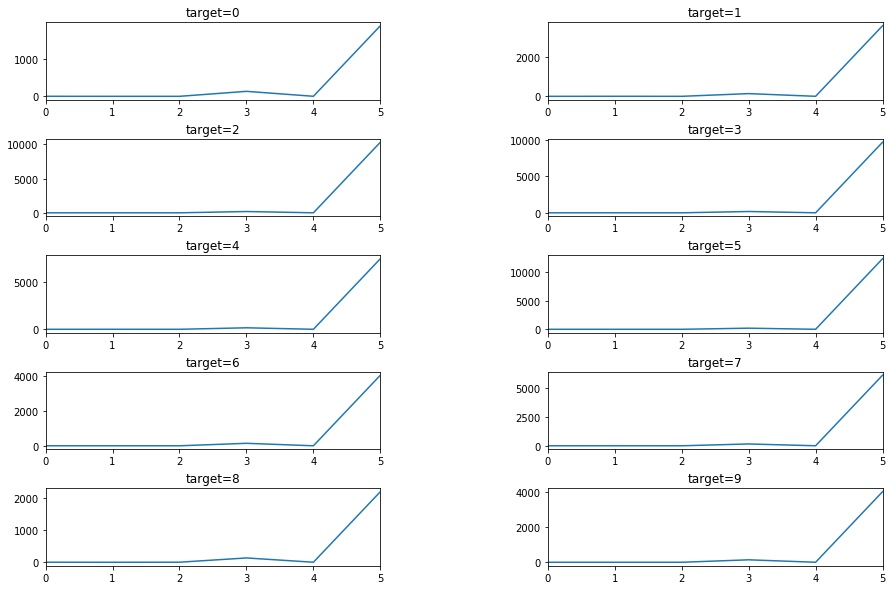

In [8]:
plt.figure(figsize=(15,10))
plt.subplots_adjust(wspace=0.5,hspace=0.5)

for i in range(10):
  plt.subplot(5,2,i+1)
  mean_df = new_mor_df[new_mor_df['target']==i].drop('target',axis=1).mean(axis=0)
  mean_df.plot()
  plt.title('target={}'.format(i))
  #plt.show()
plt.show()

In [0]:
target = new_mor_df['target']
del new_mor_df['target']
X_train, X_test, y_train, y_test = train_test_split(new_mor_df, target, test_size=0.2)

In [0]:
#svcのgrid_search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],  'gamma' : [0.001, 0.01, 0.1, 1, 10, 100], 'kernel' : ['rbf', 'linear', 'poly']}
grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train.values, y_train.values)

In [0]:
print('Test set score: {}'.format(grid_search.score(X_test.values, y_test.values)))
print('Best parameters: {}'.format(grid_search.best_params_))
print('Best cross-validation: {}'.format(grid_search.best_score_))

In [10]:
# logistic_regression 
folds = KFold(n_splits=5, shuffle=True, random_state=123)
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])
features = [f_ for f_ in X_train.columns if f_ not in ["target"]]
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_train)):
    trn_x, trn_y = X_train[features].iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = X_train[features].iloc[val_idx], y_train.iloc[val_idx]
    clf = LogisticRegression(solver='lbfgs',multi_class='multinomial')
    clf.fit(trn_x, trn_y)
    print(clf.score(val_x, val_y))

print("testACC{}".format(clf.score(X_test, y_test)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.496875
0.51875


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.45
0.4625
0.525
testACC0.49


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


###グラフの直感通り分類精度は6つの中で最も低い

### 主成分分析して特徴量をまとめ6つの特徴量から精度を測る

In [0]:
from sklearn.decomposition import PCA

In [0]:
feature_list = list([new_fou_df, new_fac_df, new_kar_df, new_pix_df, new_zer_df, new_mor_df])

In [0]:
columns = ["fou-1", "fou-2", "fac-1", "fac-2", "kar-1", "kar-2",
           "pix-1", "pix-2", "zer-1", "zer-2", "mor-1", "mor-2"]

In [41]:
"features_array = []
for feature in feature_list:
  feature_pca = pca.fit(feature)
  # データを主成分空間に写像
  feature_pca = pca.transform(feature)
  if not len(features_array):
    features_array = feature_pca
  else:
    features_array = np.hstack([features_array, feature_pca])
    
print(features_array)

[[ 5.12044949e-01 -2.34139693e-01 -6.56946626e+02 ...  4.04015340e+01
  -4.53503455e+03  6.13223914e+00]
 [ 6.48571456e-01 -2.12597939e-01 -4.05267016e+02 ... -1.71569145e+01
  -4.54596288e+03 -2.10847991e-01]
 [ 5.82051414e-01 -2.39383513e-01 -5.79456603e+02 ... -2.11635525e+01
  -4.58628962e+03  4.48953093e+00]
 ...
 [-2.36096474e-01 -2.55140751e-01  4.84458773e+02 ...  2.60339815e+01
  -2.38852809e+03 -6.25774783e+00]
 [-1.08996147e-01 -1.43350590e-01  4.77794690e+02 ...  2.30130101e+02
  -2.03691795e+03 -2.86883335e-01]
 [-2.42674432e-02 -7.46997260e-02  6.23773456e+02 ... -7.33072898e+01
  -2.34727573e+03 -7.27415523e+00]]


In [45]:
features_df = pd.DataFrame(features_array, columns=columns)
features_df.head()

,fou-1,fou-2,fac-1,fac-2,kar-1,kar-2,pix-1,pix-2,zer-1,zer-2,mor-1,mor-2
0,0.512045,-0.234140,-656.946626,-654.067417,-3.744929,-15.173051,-8.215006,-25.649540,567.826185,40.401534,-4535.034550,6.132239
1,0.648571,-0.212598,-405.267016,-642.562269,-1.699656,-9.458715,-3.524674,-17.669348,407.426733,-17.156914,-4545.962877,-0.210848
2,0.582051,-0.239384,-579.456603,-693.736597,-4.843909,-9.568765,-12.638352,-17.052124,525.116708,-21.163552,-4586.289616,4.489531
3,0.605390,-0.136980,-450.910292,-480.464548,-2.166194,-12.129270,-4.393130,-19.626815,419.464564,20.019925,-4460.226391,1.984980
4,0.589949,-0.188867,-364.361767,-348.880349,-7.444568,-9.102944,-14.563755,-15.176028,482.238582,-23.739664,-4507.574785,0.078716


In [0]:
X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.2)

In [50]:
# logistic_regression 
folds = KFold(n_splits=5, shuffle=True, random_state=123)
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])
features = [f_ for f_ in X_train.columns if f_ not in ["target"]]
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_train)):
    trn_x, trn_y = X_train[features].iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = X_train[features].iloc[val_idx], y_train.iloc[val_idx]
    clf = LogisticRegression(solver='lbfgs',multi_class='multinomial')
    clf.fit(trn_x, trn_y)
    print(clf.score(val_x, val_y))

print("testACC{}".format(clf.score(X_test, y_test)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.7875
0.821875


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.8625
0.79375
0.853125
testACC0.8225


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [0]:
#facに加える
fac_features_df = pd.concat([new_fac_df, features_df], axis=1)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(fac_features_df, target, test_size=0.2)

In [58]:
# logistic_regression 
folds = KFold(n_splits=5, shuffle=True, random_state=123)
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])
features = [f_ for f_ in X_train.columns if f_ not in ["target"]]
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X_train)):
    trn_x, trn_y = X_train[features].iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = X_train[features].iloc[val_idx], y_train.iloc[val_idx]
    clf = LogisticRegression(solver='lbfgs',multi_class='multinomial')
    clf.fit(trn_x, trn_y)
    print(clf.score(val_x, val_y))

print("testACC{}".format(clf.score(X_test, y_test)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.975


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.96875


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.940625


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.9625
0.953125
testACC0.97


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [0]:
lgb_params = {
    "objective" : "multiclass",
    "num_class" : "10",
    "boosting" : 'gbdt',
}

In [0]:
import lightgbm as lgb

In [0]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [79]:
model = lgb.train(
    lgb_params, 
    lgb_train,
    valid_sets=lgb_eval
)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_max = np.argmax(y_pred, axis=1)  # 最尤と判断したクラスの値にする
# 精度 (Accuracy) を計算する
accuracy = sum(y_test == y_pred_max) / len(y_test)
print(accuracy)

[1]	valid_0's multi_logloss: 1.91269
[2]	valid_0's multi_logloss: 1.65391
[3]	valid_0's multi_logloss: 1.45855
[4]	valid_0's multi_logloss: 1.30049
[5]	valid_0's multi_logloss: 1.17016
[6]	valid_0's multi_logloss: 1.06145
[7]	valid_0's multi_logloss: 0.970033
[8]	valid_0's multi_logloss: 0.885901
[9]	valid_0's multi_logloss: 0.812218
[10]	valid_0's multi_logloss: 0.747315
[11]	valid_0's multi_logloss: 0.69018
[12]	valid_0's multi_logloss: 0.638561
[13]	valid_0's multi_logloss: 0.592456
[14]	valid_0's multi_logloss: 0.549731
[15]	valid_0's multi_logloss: 0.512144
[16]	valid_0's multi_logloss: 0.477747
[17]	valid_0's multi_logloss: 0.446897
[18]	valid_0's multi_logloss: 0.418288
[19]	valid_0's multi_logloss: 0.392734
[20]	valid_0's multi_logloss: 0.369966
[21]	valid_0's multi_logloss: 0.34788
[22]	valid_0's multi_logloss: 0.327749
[23]	valid_0's multi_logloss: 0.309415
[24]	valid_0's multi_logloss: 0.292064
[25]	valid_0's multi_logloss: 0.276724
[26]	valid_0's multi_logloss: 0.263077
[27

### 説明力弱いが精度が最も期待できるLightGBMでは98%以上の精度

In [0]:
#